In [169]:
!pip install opencv-python-headless

In [170]:
import os
import cv2 # OpenCV
import numpy as np
import tensorflow as tf
from ultralytics import YOLO
import matplotlib.pyplot as plt

# ---------------------------------
# 1. КОНФІГУРАЦІЯ
# ---------------------------------
print("--- Етап 1: Завантаження моделей ---")

# --- ВКАЖІТЬ ПРАВИЛЬНІ ШЛЯХИ ДО ВАШИХ МОДЕЛЕЙ ---

# Шлях до Детектора (YOLO)
# Знайдіть його у папці /runs/detect/train.../
YOLO_MODEL_PATH = './runs/detect/train9/weights/best.pt'

# Шлях до Класифікатора (Keras)
CLASSIFIER_MODEL_PATH = "../models/digit_classifier_best.keras"

# --- ВКАЖІТЬ ШЛЯХ ДО ЗОБРАЖЕННЯ ДЛЯ ТЕСТУ ---
# Візьміть будь-яке з папки ../data_number/valid/images/

# Параметри класифікатора (мають збігатися з тими, на яких вчили)
CLASSIFIER_IMG_SIZE = (64, 64)
CLASS_NAMES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '11']

# ---------------------------------
# 2. ЗАВАНТАЖЕННЯ МОДЕЛЕЙ
# ---------------------------------
# [ ... ВЕСЬ КОД ДО ЦЬОГО ЗАЛИШАЄТЬСЯ БЕЗ ЗМІН ... ]

# ---------------------------------
# 2. НОВА ФУНКЦІЯ ПЕРЕДОБРОБКИ (v3 - Ваша ідея)
# ---------------------------------

def preprocess_for_classifier(image_crop_gray, target_size=(64, 64)):
    """
    Нормалізує розмір:
    1. Вписує зображення у (32, 32) зі збереженням пропорцій (letterbox).
    2. Вставляє цей (32, 32) у центр (64, 64).
    3. Інвертує (Білий текст / Чорний фон).
    """
    INNER_BOX_SIZE = (48, 48)

    # --- 1. Вписуємо в (32, 32) зі збереженням пропорцій ---
    h, w = image_crop_gray.shape[:2]

    # Запобігаємо діленню на нуль, якщо кроп порожній
    if h == 0 or w == 0:
        # Повертаємо порожній тензор
        return np.zeros((1, target_size[0], target_size[1], 1), dtype=np.float32)

    scale = min(INNER_BOX_SIZE[0] / h, INNER_BOX_SIZE[1] / w)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Переконуємось, що розмір не нульовий
    if new_h <= 0 or new_w <= 0:
        new_h, new_w = 1, 1 # Мінімальний розмір

    resized_img = cv2.resize(image_crop_gray, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Рахуємо поля для (32, 32)
    delta_w = INNER_BOX_SIZE[1] - new_w
    delta_h = INNER_BOX_SIZE[0] - new_h
    top_32, bottom_32 = delta_h // 2, delta_h - (delta_h // 2)
    left_32, right_32 = delta_w // 2, delta_w - (delta_w // 2)

    # 'letterboxed_32' - це наше зображення, вписане в (32, 32)
    letterboxed_32 = cv2.copyMakeBorder(resized_img, top_32, bottom_32, left_32, right_32,
                                        cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # --- 2. Створюємо фінальний холст (64, 64) ---
    final_image = np.zeros(target_size, dtype=np.uint8)

    # --- 3. Вставляємо (32, 32) в центр (64, 64) ---
    paste_y = (target_size[0] - INNER_BOX_SIZE[0]) // 2
    paste_x = (target_size[1] - INNER_BOX_SIZE[1]) // 2

    final_image[paste_y : paste_y + INNER_BOX_SIZE[0],
                 paste_x : paste_x + INNER_BOX_SIZE[1]] = letterboxed_32

    # --- 4. Інвертуємо (Білий текст на Чорному фоні) ---
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    # --- 5. Готуємо тензор (Keras очікує float32) ---
    final_image_float = final_image.astype(np.float32)
    input_tensor = np.expand_dims(final_image_float, axis=0)
    input_tensor = np.expand_dims(input_tensor, axis=-1)

    return input_tensor


try:
    # Завантажуємо Детектор
    detector_model = YOLO(YOLO_MODEL_PATH)
    print(f"Детектор (YOLO) завантажено з: {YOLO_MODEL_PATH}")

    # Завантажуємо Класифікатор
    classifier_model = tf.keras.models.load_model(CLASSIFIER_MODEL_PATH)
    print(f"Класифікатор (Keras) завантажено з: {CLASSIFIER_MODEL_PATH}")

except Exception as e:
    print(f"Помилка завантаження моделі: {e}")
    print("Перевірте, чи правильні шляхи у КОНФІГУРАЦІЇ.")


--- Етап 1: Завантаження моделей ---
Детектор (YOLO) завантажено з: ./runs/detect/train9/weights/best.pt
Класифікатор (Keras) завантажено з: ../models/digit_classifier_best.keras


In [171]:

print("\n--- Етап 2: Обробка зображення ---")

# ---------------------------------
# 3. ЕТАП ДЕТЕКЦІЇ (YOLO)
# ---------------------------------

# Завантажуємо тестове зображення
TEST_IMAGE_PATH = './learning/data_number/valid/images/img_00020.png'
original_image = cv2.imread(TEST_IMAGE_PATH)
if original_image is None:
    print(f"Помилка: не вдалося завантажити зображення {TEST_IMAGE_PATH}")
else:
    print(f"Тестове зображення завантажено: {TEST_IMAGE_PATH}")
# Подаємо зображення на Детектор
# conf=0.5 означає, що ми ігноруємо знахідки з упевненістю < 50%
results = detector_model.predict(original_image, conf=0.5)
detections = results[0].boxes.data.cpu().numpy() # [x1, y1, x2, y2, conf, class_id]
print(f"Знайдено {len(detections)} об'єктів (цифр).")



--- Етап 2: Обробка зображення ---
Тестове зображення завантажено: ./learning/data_number/valid/images/img_00020.png

0: 640x640 1 0, 2 4s, 1 5, 1 6, 34.6ms
Speed: 3.4ms preprocess, 34.6ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)
Знайдено 5 об'єктів (цифр).


  > Знайдено '5' (впевненість: 100.0%) на позиції X=212
  > Знайдено '7' (впевненість: 91.9%) на позиції X=244
  > Знайдено '0' (впевненість: 95.3%) на позиції X=306
  > Знайдено '0' (впевненість: 100.0%) на позиції X=276
  > Знайдено '5' (впевненість: 100.0%) на позиції X=341


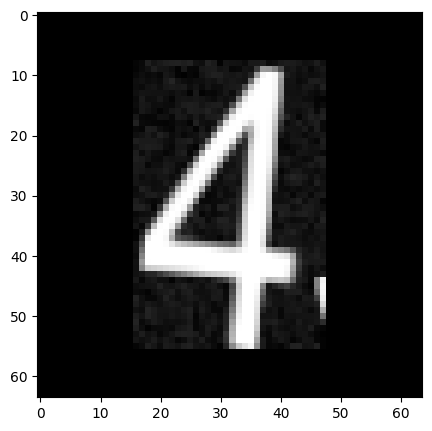

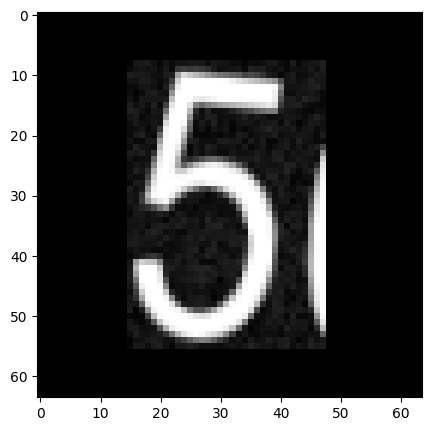

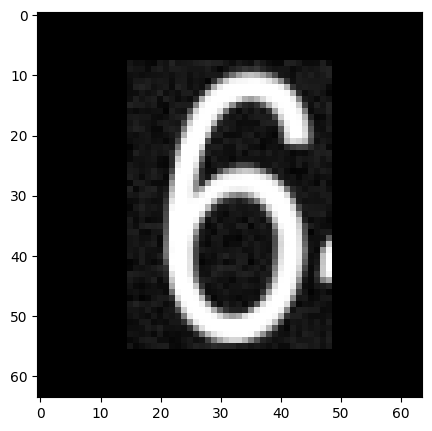

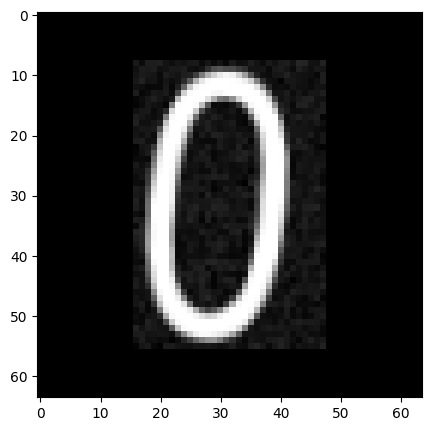

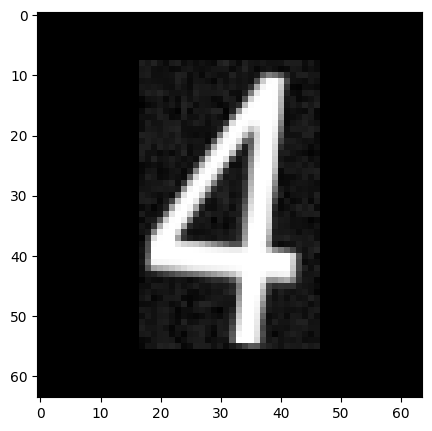

In [172]:
# ---------------------------------
# 4. ЕТАП КЛАСИФІКАЦІЇ (KERAS)
# ---------------------------------
recognized_digits = []
annotated_image = original_image.copy()

for detection in detections:
    x1, y1, x2, y2 = map(int, detection[:4])

    # 1. Вирізаємо цифру (з невеликими полями)
    padding = 0 # Зменшив padding, щоб він не захоплював сусідні цифри
    cropped_digit_bgr = original_image[max(0, y1-padding):min(original_image.shape[0], y2+padding),
                                       max(0, x1-padding):min(original_image.shape[1], x2+padding)]

    if cropped_digit_bgr.size == 0:
        continue

    # 2. Передобробка для Класифікатора (конвертація в сірий)
    cropped_digit_gray = cv2.cvtColor(cropped_digit_bgr, cv2.COLOR_BGR2GRAY)

    # 3. ВИКОРИСТОВУЄМО НОВУ ФУНКЦІЮ (з letterbox)
    input_tensor = preprocess_for_classifier(cropped_digit_gray, CLASSIFIER_IMG_SIZE)

    # 4. Прогноз Класифікатора
    prediction = classifier_model.predict(input_tensor, verbose=0)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = CLASS_NAMES[predicted_class_id]
    confidence = np.max(prediction)

    # 5. Фільтруємо "сміття"
    if predicted_class_name == 'GARBAGE':
        print(f"  > Знайдено об'єкт (ймовірно, сміття), ігноруємо.")
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 255), 2)
        continue

    # 6. Зберігаємо результат
    print(f"  > Знайдено '{predicted_class_name}' (впевненість: {confidence*100:.1f}%) на позиції X={x1}")
    recognized_digits.append((x1, predicted_class_name))

    # Малюємо рамку і підпис
    cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(annotated_image, predicted_class_name, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

In [173]:
# ---------------------------------
# 5. ЕТАП ЗБІРКИ
# ---------------------------------

# Сортуємо знайдені цифри за їхньою X-координатою (зліва направо)
recognized_digits.sort(key=lambda d: d[0])

# Збираємо фінальне число
final_number_str = "".join([digit for (x, digit) in recognized_digits])

print("\n--- ✅ ФІНАЛЬНИЙ РЕЗУЛЬТАТ ---")
print(f"Розпізнане число: {final_number_str}")


--- ✅ ФІНАЛЬНИЙ РЕЗУЛЬТАТ ---
Розпізнане число: 57005


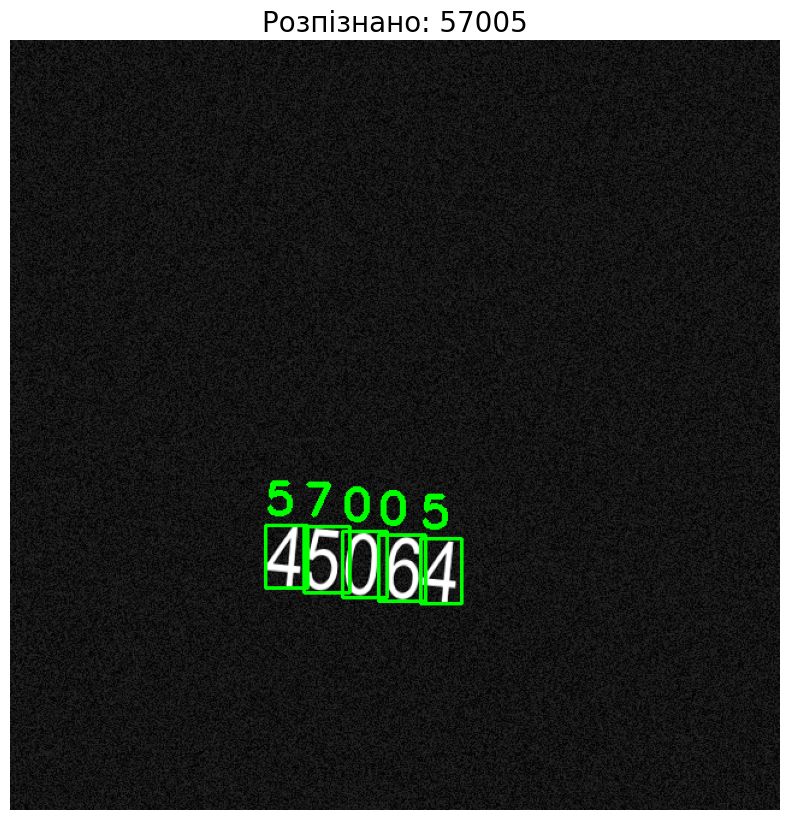

In [174]:


# ---------------------------------
# 6. ВІЗУАЛІЗАЦІЯ
# ---------------------------------

# Відображаємо зображення з рамками
# (конвертуємо BGR в RGB для Matplotlib)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title(f"Розпізнано: {final_number_str}", fontsize=20)
plt.axis('off')
plt.show()